In [1]:
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import seaborn as sns

In [2]:
class GridWorld:
    def __init__(self, rows, cols, start, terminal_states, rewards):
        self.rows = rows
        self.cols = cols
        self.start = start
        self.terminal_states = terminal_states
        self.rewards = rewards
        self.state = start

    def reset(self):
        self.state = self.start
        return self.state

    def step(self, action):
        """
        Take an action and return (next_state, reward, done).
        """
        row, col = self.state
        if self.state in self.terminal_states:
            return self.state, 0, True  # Terminal state, no reward

        if action == 'U':
            row = max(0, row - 1)
        elif action == 'D':
            row = min(self.rows - 1, row + 1)
        elif action == 'L':
            col = max(0, col - 1)
        elif action == 'R':
            col = min(self.cols - 1, col + 1)

        self.state = (row, col)
        reward = self.rewards.get(self.state, -1)  # Default reward is -1
        done = self.state in self.terminal_states
        return self.state, reward, done

    def get_actions(self):
        return ['U', 'D', 'L', 'R']

In [3]:
def plot_values(values, title):
    """
    Plot the state-value function as a heatmap.
    """
    values_grid = np.zeros((env.rows, env.cols))
    for (row, col), value in values.items():
        values_grid[row, col] = value
    plt.figure(figsize=(6, 6))
    sns.heatmap(values_grid, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title(title)
    plt.show()

In [4]:
def generate_episode(policy, env, max_steps=100):
    """
    Generate an episode using a policy function.
    """
    episode = []
    state = env.reset()
    for _ in range(max_steps):
        action_probabilities = policy(state)  # Call the policy function
        action = np.random.choice(env.get_actions(), p=action_probabilities)
        next_state, reward, done = env.step(action)
        episode.append((state, action, reward))
        if done:
            break
        state = next_state
    return episode

In [5]:
def monte_carlo_prediction(policy, env, num_episodes=500, discount_factor=0.9):
    """
    Estimate state-value function using first-visit MC.
    """
    returns_sum = defaultdict(float)
    returns_count = defaultdict(int)
    V = defaultdict(float)

    for _ in range(num_episodes):
        episode = generate_episode(policy, env)
        states_in_episode = set([x[0] for x in episode])
        for state in states_in_episode:
            first_occurrence_idx = next(i for i, x in enumerate(episode) if x[0] == state)
            G = sum([x[2] * (discount_factor ** i) for i, x in enumerate(episode[first_occurrence_idx:])])
            returns_sum[state] += G
            returns_count[state] += 1
            V[state] = returns_sum[state] / returns_count[state]
    return V

In [6]:
# Monte Carlo Control
def monte_carlo_control(env, num_episodes=1000, discount_factor=0.9, epsilon=0.1):
    """
    Monte Carlo Control using ε-greedy policy improvement.
    """
    actions = env.get_actions()
    Q = defaultdict(lambda: np.zeros(len(actions)))  # Action-value function
    returns_sum = defaultdict(float)
    returns_count = defaultdict(int)

    def create_epsilon_greedy_policy(Q, epsilon, nA):
        """
        Create an ε-greedy policy based on a Q-function and epsilon.
        """
        def policy_fn(state):
            A = np.ones(nA, dtype=float) * epsilon / nA
            best_action = np.argmax(Q[state])
            A[best_action] += 1.0 - epsilon
            return A
        return policy_fn

    policy = create_epsilon_greedy_policy(Q, epsilon, len(actions))

    for _ in range(num_episodes):
        # Generate an episode using the current policy
        episode = generate_episode(policy, env)

        # Find all state-action pairs in the episode
        state_action_pairs = set((x[0], x[1]) for x in episode)
        for state, action in state_action_pairs:
            first_occurrence_idx = next(i for i, x in enumerate(episode) if x[0] == state and x[1] == action)
            G = sum([x[2] * (discount_factor ** i) for i, x in enumerate(episode[first_occurrence_idx:])])
            returns_sum[(state, action)] += G
            returns_count[(state, action)] += 1
            Q[state][actions.index(action)] = returns_sum[(state, action)] / returns_count[(state, action)]

    # Derive the optimal policy from Q
    optimal_policy = {state: np.eye(len(actions))[np.argmax(Q[state])] for state in Q}
    return Q, optimal_policy

In [7]:
# Initialize the environment
rows, cols = 4, 4
start = (0, 0)
terminal_states = [(3, 3)]
rewards = {state: 0 for state in terminal_states}
env = GridWorld(rows, cols, start, terminal_states, rewards)

In [8]:
# Initialize the random policy
actions = env.get_actions()
random_policy = lambda state: np.ones(len(actions)) / len(actions)

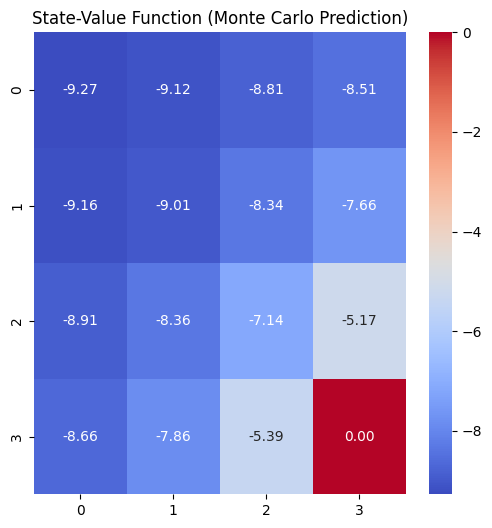

In [9]:
# Monte Carlo Prediction
V = monte_carlo_prediction(random_policy, env, num_episodes=1000)
plot_values(V, "State-Value Function (Monte Carlo Prediction)")

In [10]:
# Monte Carlo Control
Q, optimal_policy = monte_carlo_control(env, num_episodes=1000, epsilon=0.1)

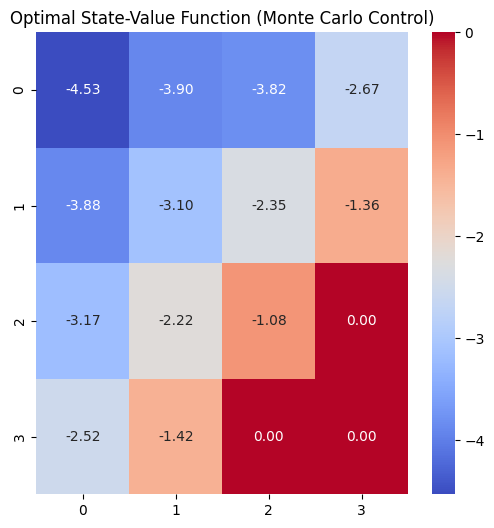

In [11]:
# Extract state-value function from Q
V_optimal = {state: max(action_values) for state, action_values in Q.items()}
plot_values(V_optimal, "Optimal State-Value Function (Monte Carlo Control)")